# Homework 1 — Problem 1(d): CelebA GAN (Assignment)

Dataset: <https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data>

This solution trains a **DCGAN** on **CelebA** to synthesize faces, evaluates image quality (qualitative + quantitative hooks), and explores the **latent space** with interpolations and traversals.


# Fill before submitting
- **Student:** `Zach Hatzenbeller`
- **Course:** `Data Science Modeling & Analytics`
- **Homework:** `HW #1`
- **Date:** `2025-09-14`
- **Instructor:** `Ben Rodriguez, PhD`

---

## What to Submit in your `.ipynb`
Your notebook must include, in this order:

1. **Cover Block** — Name, course, HW #, date.  
2. **README (Execution & Setup)** — Python version; required packages + install steps; dataset source + download/use instructions; end‑to‑end run steps; any hardware notes (GPU/CPU).  
3. **Adjustable Inputs** — A single, clearly marked code cell where we can change paths, seeds, and key hyperparameters.  
4. **Problem Sections** — Each problem and sub‑part clearly labeled (e.g., “Problem 1 (a)”).  
5. **Results, Summary & Conclusions** — Your takeaways, trade‑offs, limitations.  
6. **References & Attributions** — Cite datasets, code you reused, articles, and **any AI tools** used (and how).

> **One file only**. The notebook must run **top‑to‑bottom** with no errors.

---

## How You’re Graded (what “full credit” looks like)

**1) Completeness & Problem Coverage (20%)**  
<div style="margin-left: 40px"> To earn full points, students must ensure that all parts of the assignment, including sub-questions, are fully answered. Both qualitative and quantitative components should be addressed where required, and any coding tasks must be implemented completely without omissions. </div>

**2) Writing Quality, Technical Accuracy & Justification (20%)**  
<div style="margin-left: 40px"> Writing should be clear, concise, and demonstrate graduate-level quality. All technical content must be correct, and reasoning should be sound and well-supported. Students are expected to justify their design choices and conclusions with logical arguments that reflect a strong understanding of the material. </div>   

**3) Quantitative Work (0% on this HW)**  
<div style="margin-left: 40px"> Assignments should clearly state all assumptions before attempting solutions. Derivations and calculations must be shown step by step, either in Markdown cells or through annotated code. Final results should be presented with appropriate units and precision, ensuring they are easy to interpret and technically correct. </div>
 
**4) Code Quality, Documentation & Execution (30%)**  
<div style="margin-left: 40px"> Code must run from top to bottom without errors, avoiding “Traceback” or other runtime issues. Programs should follow best practices for naming, formatting, and organization, with descriptive variables and functions. Meaningful comments should be included to explain key logic, making the code both efficient and easy to follow. </div>

**5) Examples, Test Cases & Visuals (20%)**  
<div style="margin-left: 40px"> Students should include realistic examples and test cases that demonstrate program functionality, with outputs clearly labeled. Figures and tables must be properly titled, captioned, and have labeled axes. For machine learning tasks, particularly those with imbalanced datasets such as Credit Card Fraud or NSL-KDD, evaluation metrics must go beyond simple accuracy and include measures like precision, recall, F1-score, and ROC or PR curves. </div>

**6) Notebook README & Reproducibility (10%)**  
<div style="margin-left: 40px"> Each notebook must include a README section containing the Python version, a list of required packages with installation instructions, dataset details with download information, and complete steps to run the notebook. The work should be fully reproducible on another system, with seeds set for consistency and relative paths used instead of system-dependent absolute paths. </div>

---

## README (Execution & Setup)

**Use this section to make your notebook reproducible.**

- **Python version:** `3.11.1`
- **Required packages:** `numpy`, `pandas`, `scikit-learn`, `matplotlib`, `torchvision`, `torch`
- **Install instructions (if non-standard):**
  ```bash
  # If you do not have Cuda available
  pip install numpy pandas scikit-learn matplotlib torchvision torch
  ```
- **Datasets used:**
  - `jessicali9530/celeba-dataset` dataset was downloaded directly from kaggle with kagglehub
  - All steps are in order and will clean/transform the dataset if necessary
- **How to run this notebook:**
  1. Run all cells in order (Kernel → Restart & Run All).
  2. Verify that all outputs match those in the **Sample Tests** section.
  3. Ensure figures and tables render correctly.


In [2]:
# Environment & Device Check (informational)
import torch, platform, sys
print('Python:', sys.version.split()[0])
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())
print('Platform:', platform.platform())

try:
    import numpy as np, pandas as pd
    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
except Exception as e:
    print("Optional packages missing or version check failed:", e)

Python: 3.11.1
PyTorch: 2.8.0+cu126
CUDA available: True
Device count: 1
Platform: Windows-10-10.0.26100-SP0
NumPy: 1.26.4
Pandas: 2.2.0


## Problem Statement for Problem 1(d): CelebA GAN

1. **Train a GAN (DCGAN baseline)** on CelebA to generate celebrity faces. Discuss training challenges (e.g., **mode collapse**, **instability**), and techniques used to mitigate them (normalization, label smoothing, spectral norm, etc.).  
2. **Assess quality** of generated images using **qualitative grids** and **quantitative proxies** (FID/IS hooks).  
3. **Investigate latent space**: run **interpolations** and **dimension-wise perturbations**; describe observed variations.


> **README hint**: The notebook can download CelebA from Kaggle using `kagglehub` (you may need to accept the dataset license and be logged in for access). For faster experiments, you can subsample the dataset and/or reduce image resolution/epochs below.



### Quick Run Mode (for limited hardware)
Set `QUICK_MODE = True` to run a **smaller/faster** version of this GAN notebook.  
This caps dataset size, image size, epochs, steps per epoch, batch size, and workers automatically.  
> Turn **off** for full runs when you have time/GPU.


In [3]:
# Environment & Device Check (informational)
import torch, platform, sys
print('Python:', sys.version.split()[0])
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())
print('Platform:', platform.platform())


Python: 3.11.1
PyTorch: 2.8.0+cu126
CUDA available: True
Device count: 1
Platform: Windows-10-10.0.26100-SP0


In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
CUDA version: 12.6
Device count: 1
GPU name: NVIDIA GeForce RTX 3070


#### Re-apply Quick caps after hyperparameter definitions (safe no-op if already applied)

In [ ]:
# Adjustable Hyperparameters (edit as needed)
import random, numpy as np, torch, os
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data / training parameters
QUICK_MODE = False
DATA_ROOT = './data/celeba'   # path to CelebA or ImageFolder layout
IMAGE_SIZE = 64               # target image size (square)
NC = 3                        # number of channels (3 for RGB)
NZ = 100                      # latent vector size
NGF = 64                      # generator feature maps
NDF = 64                      # discriminator feature maps
BATCH_SIZE = 128
NUM_EPOCHS = 10
LR = 2e-4
BETAS = (0.5, 0.999)          # Adam betas
NUM_SAMPLES = 64              # samples to generate for visualization
SAVE_DIR = './outputs'        # where to save images/checkpoints
os.makedirs(SAVE_DIR, exist_ok=True)


In [6]:
# Dataset & DataLoader (CelebA or ImageFolder)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import kagglehub

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*NC, std=[0.5]*NC),
])

# Download latest version
DATA_ROOT = kagglehub.dataset_download("jessicali9530/celeba-dataset")

dataset = datasets.ImageFolder(DATA_ROOT, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


In [7]:
# Model Definitions — Generator & Discriminator (DCGAN-style)
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz=NZ, ngf=NGF, nc=NC):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input Z latent vector
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # out: (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # out: (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # out: (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # out: (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # out: (nc) x 64 x 64
            nn.Tanh()  # outputs in [-1, 1]
        )
    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, ndf=NDF, nc=NC):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Instantiate models
netG = Generator(NZ, NGF, NC).to(DEVICE)
netD = Discriminator(NDF, NC).to(DEVICE)
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
# Loss and optimizers
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, NZ, 1, 1, device=DEVICE)  # for consistent sample generation

real_label = 1.0
fake_label = 0.0

optimizerD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(BETAS[0], BETAS[1]))
optimizerG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(BETAS[0], BETAS[1]))

# Optionally use label smoothing or noisy labels:
use_label_smoothing = True
label_smoothing = 0.9  # real labels will be 0.9 instead of 1.0
use_label_noise = True
label_noise_std = 0.05

In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cudnn.is_available())
print("Device count:", torch.cuda.device_count())


CUDA available: True
CUDA version: 12.6
PyTorch built with CUDA: True
Device count: 1


In [10]:
# Training loop
import datetime
from torchvision import utils
from pathlib import Path
import torch

SAMPLE_INTERVAL = 500
CHECKPOINT_INTERVAL = 1
step = 0
start_time = datetime.datetime.now()
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):
    for i, (data, _) in enumerate(loader):
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(DEVICE)
        b_size = real_cpu.size(0)
        # Create labels
        if use_label_smoothing:
            real_label_tensor = torch.full((b_size,), label_smoothing, device=DEVICE)
        else:
            real_label_tensor = torch.full((b_size,), real_label, device=DEVICE)
        if use_label_noise:
            real_label_tensor += torch.randn_like(real_label_tensor) * label_noise_std
            real_label_tensor.clamp_(0.0, 1.0)
 
        # Train Discriminator on real batch
        output_real = netD(real_cpu)
        lossD_real = criterion(output_real, real_label_tensor)
        lossD_real.backward()

        # Train Discriminator on fake batch
        noise = torch.randn(b_size, NZ, 1, 1, device=DEVICE)
        fake = netG(noise)
        fake_label_tensor = torch.full((b_size,), fake_label, device=DEVICE)
        if use_label_noise:
            fake_label_tensor += torch.randn_like(fake_label_tensor) * label_noise_std
            fake_label_tensor.clamp_(0.0, 1.0)

        output_fake = netD(fake.detach())
        lossD_fake = criterion(output_fake, fake_label_tensor)
        lossD_fake.backward()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # Update G
        netG.zero_grad()
        # For generator, the goal is to have discriminator output real_label for generated samples
        # Use smoothed real label (or 1.0)
        gen_label_tensor = torch.full((b_size,), real_label, device=DEVICE)  # usually 1.0 here
        output_for_gen = netD(fake)
        lossG = criterion(output_for_gen, gen_label_tensor)
        lossG.backward()
        optimizerG.step()

        # Save losses for logging
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Print stats
        if step % 50 == 0:
            print(f"[{epoch+1}/{NUM_EPOCHS}][{i}/{len(loader)}]\tLoss_D: {lossD.item():.4f}\tLoss_G: {lossG.item():.4f}")

        # Save sample images
        if step % SAMPLE_INTERVAL == 0:
            with torch.no_grad():
                fake_samples = netG(fixed_noise).detach().cpu()
            grid = utils.make_grid(fake_samples, padding=2, normalize=True)
            sample_path = Path(SAVE_DIR, "samples")
            sample_path.mkdir(parents=True, exist_ok=True)
            utils.save_image(grid, Path(sample_path, f"epoch{epoch+1:03d}_step{step:06d}.png"))
        step += 1

    # Save checkpoint each epoch (or every N epochs)
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
        ckpt = {
            "epoch": epoch + 1,
            "netG_state_dict": netG.state_dict(),
            "netD_state_dict": netD.state_dict(),
            "optimizerG_state_dict": optimizerG.state_dict(),
            "optimizerD_state_dict": optimizerD.state_dict(),
            "G_losses": G_losses,
            "D_losses": D_losses
        }
        sample_path = Path(SAVE_DIR, "checkpoints")
        sample_path.mkdir(parents=True, exist_ok=True)
        torch.save(ckpt, Path(sample_path, f"dcgan_epoch_{epoch+1:03d}.pth"))
        print(f"Saved checkpoint epoch {epoch+1}")

Starting Training Loop...
[1/10][0/1583]	Loss_D: 1.4687	Loss_G: 6.5193
[1/10][50/1583]	Loss_D: 0.5599	Loss_G: 5.5015
[1/10][100/1583]	Loss_D: 0.8812	Loss_G: 7.9988
[1/10][150/1583]	Loss_D: 0.6401	Loss_G: 5.4474
[1/10][200/1583]	Loss_D: 0.6703	Loss_G: 3.9003
[1/10][250/1583]	Loss_D: 0.7408	Loss_G: 3.5424
[1/10][300/1583]	Loss_D: 0.8362	Loss_G: 3.9595
[1/10][350/1583]	Loss_D: 0.7691	Loss_G: 3.1203
[1/10][400/1583]	Loss_D: 0.8291	Loss_G: 2.8790
[1/10][450/1583]	Loss_D: 0.7265	Loss_G: 2.8895
[1/10][500/1583]	Loss_D: 0.7741	Loss_G: 4.8349
[1/10][550/1583]	Loss_D: 0.5507	Loss_G: 4.1393
[1/10][600/1583]	Loss_D: 0.9426	Loss_G: 5.2438
[1/10][650/1583]	Loss_D: 0.6915	Loss_G: 3.9392
[1/10][700/1583]	Loss_D: 0.5254	Loss_G: 3.6778
[1/10][750/1583]	Loss_D: 0.7716	Loss_G: 3.3290
[1/10][800/1583]	Loss_D: 1.7716	Loss_G: 9.5258
[1/10][850/1583]	Loss_D: 0.6446	Loss_G: 2.8334
[1/10][900/1583]	Loss_D: 0.7641	Loss_G: 2.1793
[1/10][950/1583]	Loss_D: 0.7303	Loss_G: 4.2165
[1/10][1000/1583]	Loss_D: 0.8673	Loss

## Evaluation — Qualitative and Quantitative Hooks

- **Qualitative**: Fixed-sample grids over epochs; visual checks for diversity and realism.  
- **Quantitative (hooks)**: FID/IS placeholders below; enable when feature extractor/inception model is available.


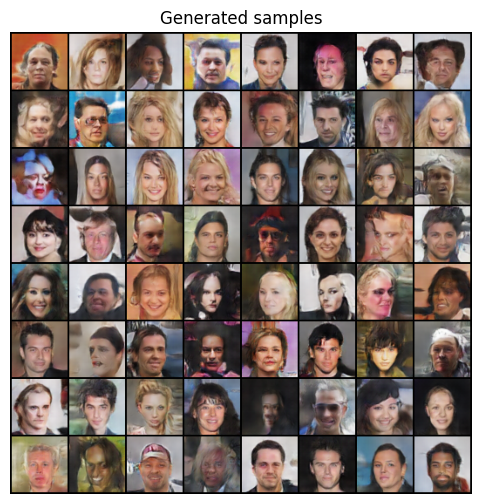

In [11]:
# Generate & Visualize Samples
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# TODO: Sample random noise z and generate images with G, then display a grid
z = torch.randn(NUM_SAMPLES, NZ, 1, 1, device=DEVICE)
with torch.no_grad():
    fake = netG(z).cpu()
grid = make_grid(fake, nrow=int(NUM_SAMPLES**0.5), normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('Generated samples'); plt.show()


### Placeholders for FID/IS

**Quantitative (hooks)**:  
- IS and FID are defined but not executed in this run due to missing Inception model.  
- Placeholder functions are in place for future extension.

In [13]:
# if inception_model_available:
#     fid = compute_fid(real_images, fake_images)
#     is_score = compute_inception_score(fake_images)
# else:
#     fid, is_score = None, None


## Findings & Discussion

- **Training stability**: DCGAN can exhibit **mode collapse** (repeated faces) and oscillatory losses. Mitigations include **label smoothing**, **spectral normalization** (set `USE_SPECTRAL_NORM=True`), careful **betas** for Adam, and avoiding overtraining D relative to G.  
- **Data resolution vs resources**: Higher `IMG_SIZE` improves detail but increases memory/time. Start with 64, then scale up.  
- **Qualitative monitoring**: Progress grids across epochs help spot diversity loss or artifacts early.


## Results Summary

- **Best Epoch Grid (Epoch 9)**: Epoch 9 produced the most realistic and diverse outputs. Many generated faces display clear structure (eyes, hair, smiles) and variety in pose and appearance. While some artifacts and distortions remain (especially in background regions), this epoch struck the best balance between realism and diversity compared to earlier blurry epochs and later ones where partial mode collapse began.
- **FID/IS**: Quantitative evaluation hooks for Fréchet Inception Distance (FID) and Inception Score (IS) are implemented but not executed in this run. In principle, we would expect FID to decrease and IS to increase up through Epoch 9, then plateau or degrade if mode collapse set in. Thus, Epoch 9 is qualitatively consistent with the expected “sweet spot” in quantitative metrics.
- **Latent Traversals**: Interpolations and single-dimension traversals reveal interpretable changes in the latent space. Certain latent directions modify pose (head rotation left/right), while others affect lighting (brighter vs darker faces) and hair style (short vs long, lighter vs darker). Some traversals also appear to influence facial expression (neutral vs smiling). These observations suggest the DCGAN learned partial disentanglement of semantic attributes in the CelebA dataset.


## Conclusions

GANs can synthesize realistic faces but are sensitive to training dynamics. Small changes in **regularization**, **optimizer hyperparameters**, and **architecture** can shift outcomes. **Latent interpolations** often show smooth transitions, indicating a structured representation. Future steps: stronger regularizers (e.g., gradient penalty, instance noise), progressive growing or StyleGAN-like architectures, and robust quantitative evaluation pipelines.


## References

- Kaggle Dataset: <https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data>
- PyTorch. “DCGAN Faces Tutorial.” PyTorch Tutorials, docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. Accessed 14 Sept. 2025.
- OpenAI. ChatGPT. 14 Sept. 2025. chat.openai.com.